# Loading and Reading from the Dataset

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset_filepath = "./dhs-quickstats_subnational_uga.csv"
resource_allocation = pd.read_csv(dataset_filepath)

print("Initial dataset shape:", resource_allocation.shape)
resource_allocation.head()


Initial dataset shape: (1828, 30)


,ISO3,Location,DataId,Indicator,Value,Precision,DHS_CountryCode,CountryName,SurveyYear,SurveyId,...,IsPreferred,SDRID,RegionId,SurveyYearLabel,SurveyType,DenominatorWeighted,DenominatorUnweighted,CILow,CIHigh,LevelRank
0,#country+code,#loc+name,#meta+id,#indicator+name,#indicator+value+num,#indicator+precision,NaN,#country+name,#date+year,#survey+id,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UGA,Central,652297,Total fertility rate 15-49,6.9,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452001,1988-89,DHS,NaN,NaN,NaN,NaN,NaN
2,UGA,Eastern,645144,Total fertility rate 15-49,7.5,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452005,1988-89,DHS,NaN,NaN,NaN,NaN,NaN
3,UGA,Northern,645191,Total fertility rate 15-49,7.4,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452008,1988-89,DHS,NaN,NaN,NaN,NaN,NaN
4,UGA,Western,645154,Total fertility rate 15-49,7.8,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452013,1988-89,DHS,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

In [137]:
# Clean column names
resource_allocation.columns = (
    resource_allocation.columns.str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

# Convert year to integer (if exists)
if "year" in resource_allocation.columns:
    resource_allocation["year"] = pd.to_numeric(
        resource_allocation["year"], errors="coerce"
    ).astype("Int64")

# Convert all object-type numeric fields
for col in resource_allocation.select_dtypes(include="object").columns:
    try:
        resource_allocation[col] = pd.to_numeric(resource_allocation[col])
    except:
        pass

# Handle missing values
if "district" in resource_allocation.columns and "year" in resource_allocation.columns:
    resource_allocation = (
        resource_allocation.sort_values(["district", "year"])
        .groupby("district")
        .apply(lambda g: g.ffill().bfill())
        .reset_index(drop=True)
    )
else:
    resource_allocation = resource_allocation.ffill().bfill()

print("After preprocessing:", resource_allocation.shape)
resource_allocation.head()


After preprocessing: (1828, 30)


,iso3,location,dataid,indicator,value,precision,dhs_countrycode,countryname,surveyyear,surveyid,...,ispreferred,sdrid,regionid,surveyyearlabel,surveytype,denominatorweighted,denominatorunweighted,cilow,cihigh,levelrank
0,#country+code,#loc+name,#meta+id,#indicator+name,#indicator+value+num,#indicator+precision,UG,#country+name,#date+year,#survey+id,...,1.0,FEFRTRWTFR,UGDHS1988452001,1988-89,DHS,928.0,1167.0,86.0,117.0,1.0
1,UGA,Central,652297,Total fertility rate 15-49,6.9,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452001,1988-89,DHS,928.0,1167.0,86.0,117.0,1.0
2,UGA,Eastern,645144,Total fertility rate 15-49,7.5,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452005,1988-89,DHS,928.0,1167.0,86.0,117.0,1.0
3,UGA,Northern,645191,Total fertility rate 15-49,7.4,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452008,1988-89,DHS,928.0,1167.0,86.0,117.0,1.0
4,UGA,Western,645154,Total fertility rate 15-49,7.8,1,UG,Uganda,1988,UG1988DHS,...,1.0,FEFRTRWTFR,UGDHS1988452013,1988-89,DHS,928.0,1167.0,86.0,117.0,1.0


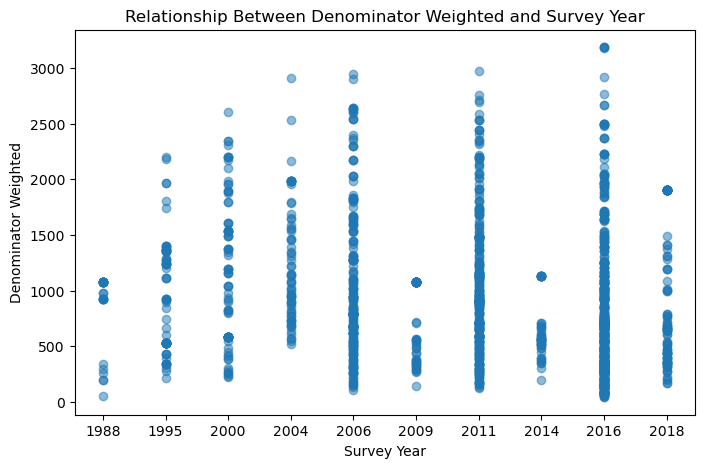

In [138]:
import matplotlib.pyplot as plt

# Dropping the first row from the entire dataset
resource_allocation = resource_allocation.iloc[1:]

plt.figure(figsize=(8,5))
plt.scatter(resource_allocation['surveyyear'], resource_allocation['denominatorweighted'], alpha=0.5)
plt.title("Relationship Between Denominator Weighted and Survey Year")
plt.xlabel("Survey Year")
plt.ylabel("Denominator Weighted")
plt.show()


# Selecting Indicators

In [139]:
resourcecopy = resource_allocation[['location', 'surveyyear', 'indicator', 'value']]
resourcecopy.columns = ['district', 'year', 'indicator', 'value']

resourcecopy = resourcecopy.dropna(subset=['district','year','indicator','value'])
resourcecopy['value'] = pd.to_numeric(resourcecopy['value'], errors='coerce')
resourcecopy = resourcecopy.dropna(subset=['value'])

# Define indicator groups
fertility_ind = ['Total fertility rate 15-49']
mortality_ind = ['Infant mortality rate', 'Under-five mortality rate']
contraceptive_ind = [
    'Married women currently using any method of contraception',
    'Married women currently using any modern method of contraception'
]
risk_indicators = [
    'Place of delivery: Health facility',
    'Fully vaccinated (8 basic antigens)',
    'Children stunted',
    'Children wasted',
    'Children underweight'
]

selected_indicators = fertility_ind + mortality_ind + contraceptive_ind + risk_indicators


# Filtering and Pivoting to Wide Format

In [140]:
resourcecopy_small = resourcecopy[resourcecopy['indicator'].isin(selected_indicators)]

pivot_resourcecopy = resourcecopy_small.pivot_table(
    index=['district', 'year'],
    columns='indicator',
    values='value',
    aggfunc='mean'
).reset_index()

pivot_resourcecopy = pivot_resourcecopy.dropna()
pivot_resourcecopy.head()


indicator,district,year,Children stunted,Children underweight,Children wasted,Fully vaccinated (8 basic antigens),Infant mortality rate,Married women currently using any method of contraception,Married women currently using any modern method of contraception,Place of delivery: Health facility,Total fertility rate 15-49,Under-five mortality rate
0,..Acholi,2016,30.6,15.4,3.9,65.1,48.0,31.3,30.2,84.566667,5.5,69.0
2,..Ankole,2016,29.3,9.9,1.8,61.8,41.0,43.1,36.2,72.633333,4.9,72.0
4,..Bugisu,2016,36.0,14.9,5.0,47.8,38.0,44.8,43.2,58.566667,5.6,68.0
6,..Bukedi,2016,22.8,12.0,2.8,52.3,43.0,40.4,34.5,68.533333,6.1,72.0
8,..Bunyoro,2016,34.5,9.1,2.3,66.9,63.0,31.2,29.6,58.000000,6.0,89.0


# Creating Scores

In [141]:
#Population Pressure Score
pivot_resourcecopy['pressure_score'] = (
    pivot_resourcecopy[fertility_ind].mean(axis=1) * 0.5 +
    (1 / (pivot_resourcecopy[mortality_ind].mean(axis=1) + 1)) * 0.3 +
    (1 - pivot_resourcecopy[contraceptive_ind].mean(axis=1)) * 0.2
)

#Nutrition Score
pivot_resourcecopy['nutrition_index'] = pivot_resourcecopy[
    ['Children stunted', 'Children wasted', 'Children underweight']
].mean(axis=1)

#Health System Demand
pivot_resourcecopy['health_service_demand'] = pivot_resourcecopy[
    ['Place of delivery: Health facility', 'Fully vaccinated (8 basic antigens)']
].mean(axis=1)

#Resource Risk Score
pivot_resourcecopy['resource_risk_score'] = (
    pivot_resourcecopy['pressure_score'] * 0.6 +
    pivot_resourcecopy['nutrition_index'] * 0.25 +
    pivot_resourcecopy['health_service_demand'] * 0.15
)


# Categorizing Pressure Score

In [142]:
high_p = pivot_resourcecopy['pressure_score'].quantile(0.75)
low_p  = pivot_resourcecopy['pressure_score'].quantile(0.25)

def categorize_pressure(x):
    if x >= high_p:
        return "High Pressure"
    elif x >= low_p:
        return "Medium Pressure"
    else:
        return "Low Pressure"

pivot_resourcecopy['pressure_category'] = pivot_resourcecopy['pressure_score'].apply(categorize_pressure)


# Categorizing Resource Risk Score

In [143]:
# Categorize Resource Risk Score
high_r = pivot_resourcecopy['resource_risk_score'].quantile(0.75)
low_r  = pivot_resourcecopy['resource_risk_score'].quantile(0.25)

def categorize_resource_risk(x):
    if x >= high_r:
        return "High Risk"
    elif x >= low_r:
        return "Medium Risk"
    else:
        return "Low Risk"

pivot_resourcecopy['resource_risk_category'] = pivot_resourcecopy['resource_risk_score'].apply(categorize_resource_risk)

print("Created resource_risk_category with value counts:")
print(pivot_resourcecopy['resource_risk_category'].value_counts())


Created resource_risk_category with value counts:
resource_risk_category
Medium Risk    24
High Risk      13
Low Risk       13
Name: count, dtype: int64


# Regression Model — Predict Pressure Score

In [144]:
# --- STAGE 1: Predict Pressure Score (Regression Model) ---

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Use all numeric columns EXCEPT pressure_score
X = pivot_resourcecopy.select_dtypes(include=['float64', 'int64'])
X = X.drop(columns=['pressure_score'], errors='ignore')

y = pivot_resourcecopy['pressure_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pressure_model = RandomForestRegressor(n_estimators=200, random_state=42)
pressure_model.fit(X_train, y_train)

y_pred_pressure = pressure_model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred_pressure))
print("R^2:", r2_score(y_test, y_pred_pressure))

# Store predicted pressure values (used in Stage 2)
pivot_resourcecopy['predicted_pressure_score'] = pressure_model.predict(X)

# Show sample predictions
print("\nSample Predicted Pressure Scores:")
print(pivot_resourcecopy[['pressure_score','predicted_pressure_score']].head(10))


MSE: 0.548941764206482
R^2: 0.907242786234734

Sample Predicted Pressure Scores:
indicator  pressure_score  predicted_pressure_score
0               -3.194958                 -3.171698
2               -5.274783                 -5.252041
4               -5.794444                 -5.689130
6               -4.234872                 -4.343496
8               -2.876104                 -2.954124
10              -2.745683                 -2.747832
12              -6.464737                 -6.293266
14              -5.684783                 -5.755888
16              -3.223684                 -3.257065
18              -5.165489                 -5.281331


# Classification Model — Predict Pressure Category

In [145]:
# --- STAGE 2: Predict Resource Risk Category (Classification) ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Build new features INCLUDING predicted pressure
X_risk = pivot_resourcecopy[[
    'predicted_pressure_score',
    'nutrition_index',
    'health_service_demand'
]]

y_risk = pivot_resourcecopy['resource_risk_category']

X_train, X_test, y_train, y_test = train_test_split(X_risk, y_risk, test_size=0.2, random_state=42)

risk_model = RandomForestClassifier(n_estimators=200, random_state=42)
risk_model.fit(X_train, y_train)

y_pred_risk = risk_model.predict(X_test)

print("\nResource Risk Classification Report:")
print(classification_report(y_test, y_pred_risk))

# Show sample predictions
print("\nSample Risk Category Predictions:")
print(pd.DataFrame({
    'Actual Risk': y_test.values,
    'Predicted Risk': y_pred_risk
}).head(10))



Resource Risk Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      0.80      0.89         5
    Low Risk       1.00      1.00      1.00         1
 Medium Risk       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.93      0.93      0.93        10
weighted avg       0.92      0.90      0.90        10


Sample Risk Category Predictions:
   Actual Risk Predicted Risk
0  Medium Risk    Medium Risk
1  Medium Risk    Medium Risk
2  Medium Risk    Medium Risk
3    High Risk      High Risk
4  Medium Risk    Medium Risk
5    High Risk    Medium Risk
6    High Risk      High Risk
7    High Risk      High Risk
8    High Risk      High Risk
9     Low Risk       Low Risk


# Visualization

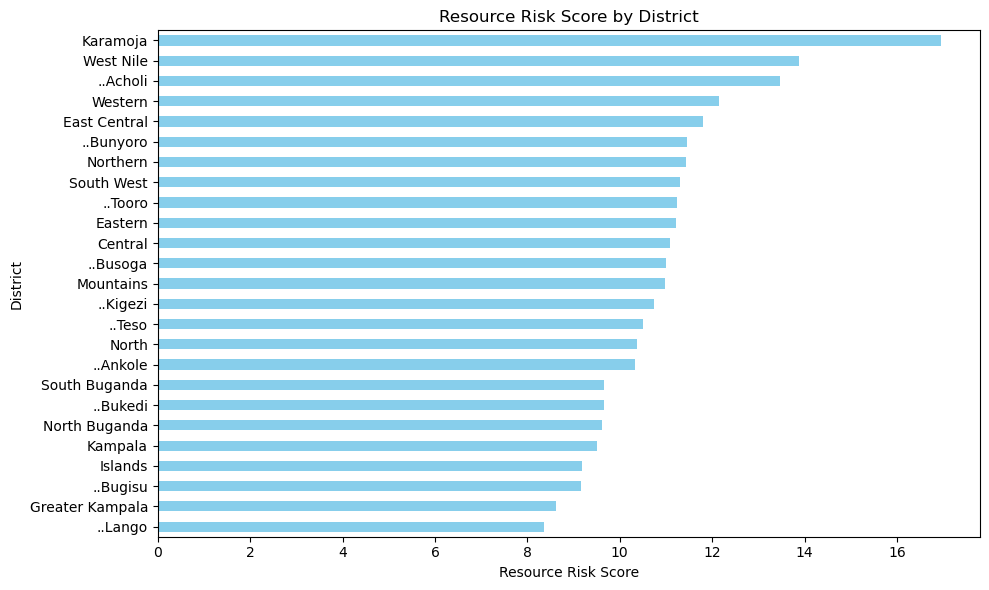

In [146]:
avg_risk = pivot_resourcecopy.groupby('district')['resource_risk_score'].mean().sort_values()

plt.figure(figsize=(10,6))
avg_risk.plot(kind='barh', color='skyblue')
plt.title("Resource Risk Score by District")
plt.xlabel("Resource Risk Score")
plt.ylabel("District")
plt.tight_layout()
plt.show()


# Predicted Pressure and Risk Visualizations

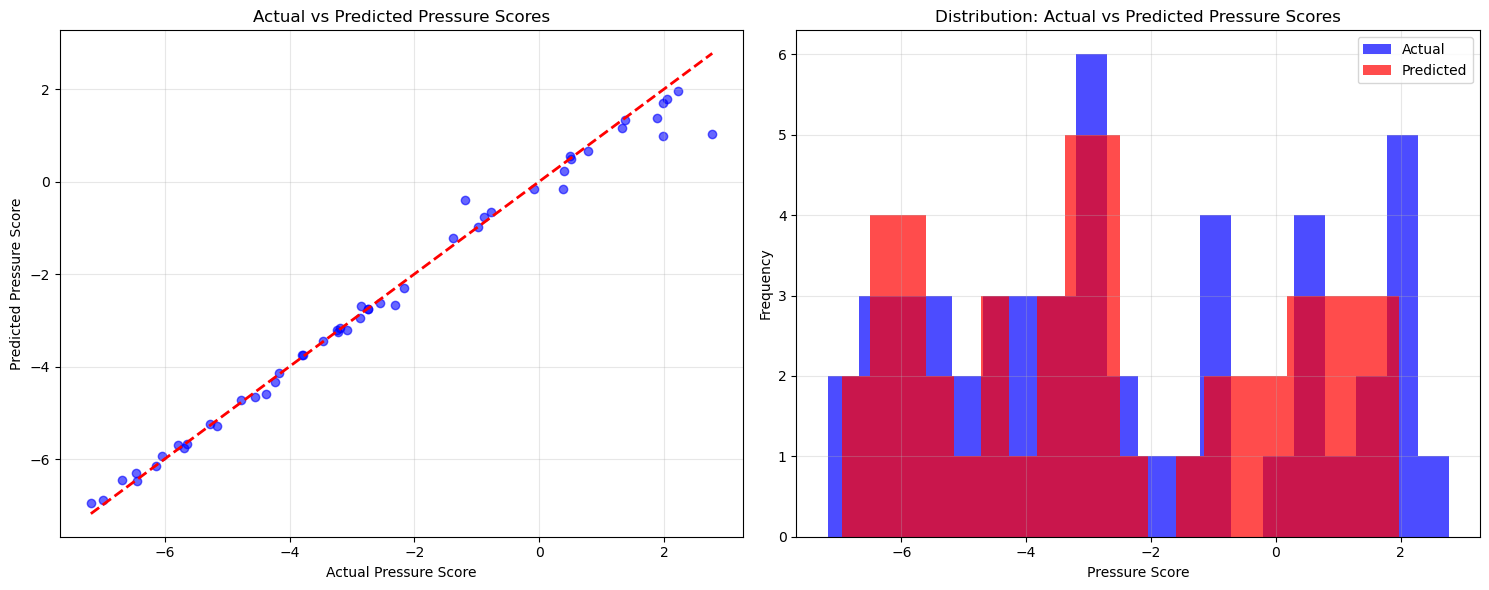

In [151]:
# Actual vs Predicted Pressure Scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot: Actual vs Predicted
ax1.scatter(pivot_resourcecopy['pressure_score'], 
           pivot_resourcecopy['predicted_pressure_score'], 
           alpha=0.6, color='blue')
ax1.plot([pivot_resourcecopy['pressure_score'].min(), pivot_resourcecopy['pressure_score'].max()], 
         [pivot_resourcecopy['pressure_score'].min(), pivot_resourcecopy['pressure_score'].max()], 
         'r--', linewidth=2)
ax1.set_xlabel('Actual Pressure Score')
ax1.set_ylabel('Predicted Pressure Score')
ax1.set_title('Actual vs Predicted Pressure Scores')
ax1.grid(True, alpha=0.3)

# Distribution comparison
ax2.hist(pivot_resourcecopy['pressure_score'], alpha=0.7, label='Actual', bins=20, color='blue')
ax2.hist(pivot_resourcecopy['predicted_pressure_score'], alpha=0.7, label='Predicted', bins=20, color='red')
ax2.set_xlabel('Pressure Score')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution: Actual vs Predicted Pressure Scores')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

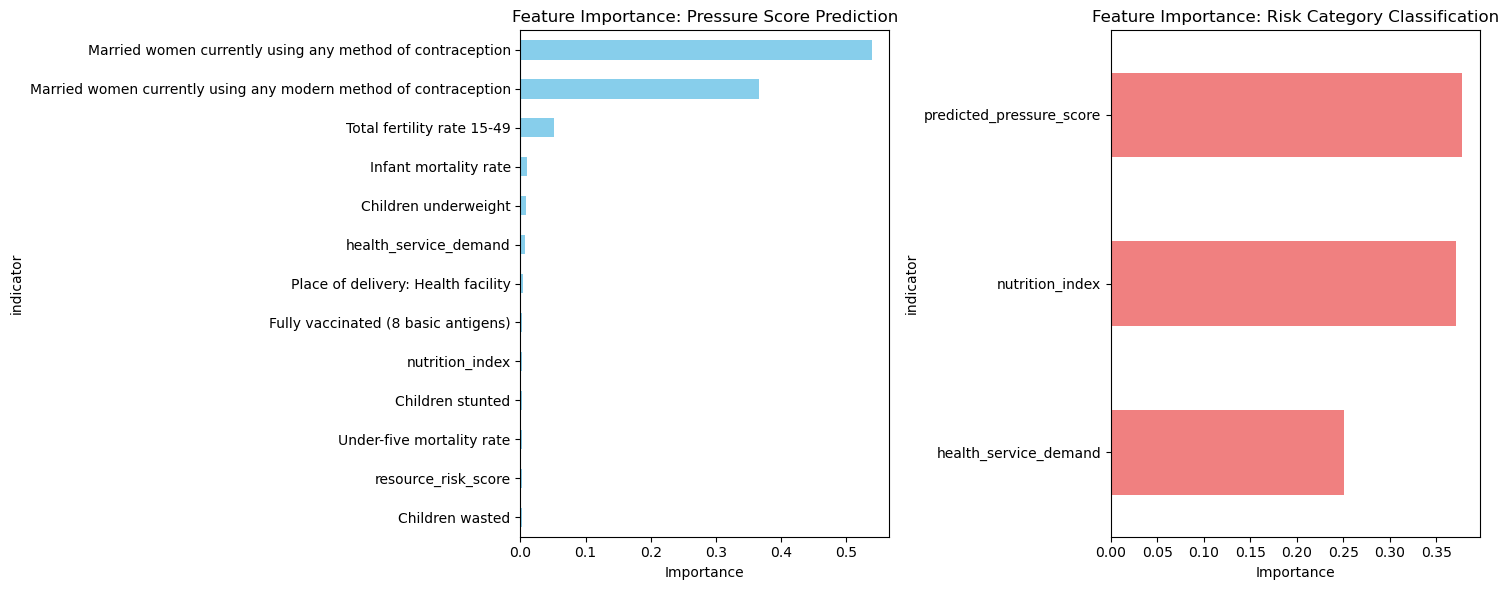

In [152]:
# Feature Importance for Predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Feature importance for pressure prediction
pressure_importance = pd.Series(pressure_model.feature_importances_, 
                               index=X.columns).sort_values(ascending=True)
pressure_importance.plot(kind='barh', ax=ax1, color='skyblue')
ax1.set_title('Feature Importance: Pressure Score Prediction')
ax1.set_xlabel('Importance')

# Feature importance for risk classification
risk_importance = pd.Series(risk_model.feature_importances_, 
                           index=X_risk.columns).sort_values(ascending=True)
risk_importance.plot(kind='barh', ax=ax2, color='lightcoral')
ax2.set_title('Feature Importance: Risk Category Classification')
ax2.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [153]:
# Summary Statistics Table
print("=== PREDICTION SUMMARY ===")
print(f"Total Districts: {pivot_resourcecopy['district'].nunique()}")
print(f"Years Covered: {pivot_resourcecopy['year'].min()} - {pivot_resourcecopy['year'].max()}")
print()

print("Pressure Score Statistics:")
print(f"  Mean: {pivot_resourcecopy['predicted_pressure_score'].mean():.3f}")
print(f"  Std:  {pivot_resourcecopy['predicted_pressure_score'].std():.3f}")
print(f"  Min:  {pivot_resourcecopy['predicted_pressure_score'].min():.3f}")
print(f"  Max:  {pivot_resourcecopy['predicted_pressure_score'].max():.3f}")
print()

print("Risk Category Distribution:")
for category, count in pivot_resourcecopy['resource_risk_category'].value_counts().items():
    percentage = (count / len(pivot_resourcecopy)) * 100
    print(f"  {category}: {count} ({percentage:.1f}%)")

print()
print("Top 5 Highest Risk Districts (by avg pressure score):")
top_risk = pivot_resourcecopy.groupby('district')['predicted_pressure_score'].mean().sort_values(ascending=False).head()
for district, score in top_risk.items():
    print(f"  {district}: {score:.3f}")

=== PREDICTION SUMMARY ===
Total Districts: 25
Years Covered: 1995 - 2016

Pressure Score Statistics:
  Mean: -2.578
  Std:  2.739
  Min:  -6.947
  Max:  1.968

Risk Category Distribution:
  Medium Risk: 24 (48.0%)
  High Risk: 13 (26.0%)
  Low Risk: 13 (26.0%)

Top 5 Highest Risk Districts (by avg pressure score):
  Karamoja: 1.201
  West Nile: 0.408
  Northern: -0.170
  Eastern: -0.519
  Western: -0.997
